In [1]:
# Today we are going to look at how to customize ML moels. 
# Now that we know how to use neural networks, we will look at customizing/shaping them
# Today we will be looking at starting with a neural network (with linear regression connections)
# Introducing local connections and parameter sharing, and arriving at a
# Locally connected network with parameter sharing, which is also called
# A convolutional neural network

In [2]:
# Let's start with remembering our linear regression basics on this dataset.
# This should be trivial and feel repetitive

In [3]:
# load in the dataset and import our dependencies
import matplotlib.pyplot as plt
from sklearn import datasets
import numpy as np
import pandas as pd
digits = datasets.load_digits()

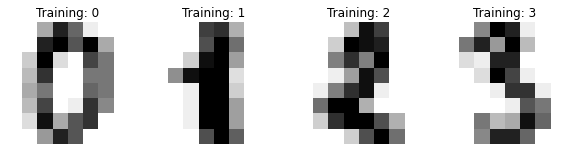

In [4]:
# Let's Visualize the dataset. Please read through and try to understand this code.
# Try removing parts and seeing what changes.
# This is a common exercise for a developer, grabbing working code and learning from it.
_, axes = plt.subplots(nrows=1, ncols=4, figsize=(10, 3))
for ax, image, label in zip(axes, digits.images, digits.target):
    ax.set_axis_off()
    ax.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')
    ax.set_title('Training: %i' % label)

In [5]:
# access and flatten our dataset
x = #TODO
y = #TODO

In [6]:
# Split the dataset into training and validation
n_data = #TODO
train_locations = #TODO
val_locations = #TODO

xtrn, ytrn = #TODO
xval, yval = #TODO

In [7]:
# Train a logistic regression model and check the accuracy
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier

lrclassifier = #TODO
yhat = #TODO
acc = #TODO
print('acc', acc.round(5))

acc 0.9196


C:\Users\leedt\anaconda3\envs\tf2\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [8]:
# Train a MLP model with [100, 100] hidden units and check the accuracy
# The accuracy should drop.
mlp = #TODO
yhat = #TODO
acc = #TODO
print('acc', acc.round(5))

acc 0.88806


In [9]:

# Here we will first demosntrate that neural networks have a way of doing better than we measured above.
def test_blackbox(digits):
    x = digits.images[:,:,:,None]
    y = pd.get_dummies(digits.target).values
    xtrn, ytrn = x[train_locations], y[train_locations]
    xval, yval = x[val_locations], y[val_locations]
    import tensorflow as tf
    from tensorflow.keras.layers import Conv2D, LeakyReLU, Flatten, Dense
    tfph = tf.compat.v1.placeholder
    tf.compat.v1.disable_eager_execution()
    xph = tfph(tf.float32, shape = (None, 8, 8, 1))
    relu = LeakyReLU()

    yph = tfph(tf.float32, shape = (None,10))
    hidden = relu(Conv2D(16, 3)(xph))
    hidden = relu(Conv2D(32, 3)(hidden))
    hidden = relu(Conv2D(64, 3, padding='same')(hidden))
    flattened = Flatten()(hidden)
    yhat = Dense(10)(flattened)
    loss = tf.nn.sigmoid_cross_entropy_with_logits(
        labels=yph, logits=yhat
    )
    # loss =tf.reduce_mean((yhat - ytrn)**2)
    opt = tf.compat.v1.train.AdamOptimizer(learning_rate=.01).minimize(loss)
    sess = tf.compat.v1.Session()
    sess.run(tf.compat.v1.global_variables_initializer())
    for i in range(100):
        _, l2 = sess.run([opt, loss], {xph:xtrn, yph: ytrn})
        if i % 10 == 0:
            predictions = sess.run(yhat, {xph:xval})
            yhatval = predictions.argmax(1)
            acc = (yhatval == yval.argmax(1)).mean()
            print(acc)

In [18]:
import random
test_blackbox(digits)

0.2634508348794063
0.6307977736549165
0.8559059987631417
0.8985776128633272
0.8961038961038961
0.9270253555967841
0.9288806431663574
0.9313543599257885
0.9338280766852195
0.935064935064935


In [11]:
# So let's think about whats going on. How can we utilize information to learn about it better.

# Let's assume that we have an image thats 1024x1024x3. To make the math simpler, lets just call it 1000x1000x3.

# How many features do we have?
# Assuming our first layer should have the same number of features as our image, how many linear regressions does our 
# First hidden layer require?
# Considering how many input features we have, how many parameters are learned 
# for each of the linear regressions of the first lyaer?
# So how many total parameters are learned by the first layer?
# 9,000,000,000,000
# Make sure you understand how to compute that number.


# That's kindve a lot, right?
# So, Now let's slow down. Let's look at a 5x5 patch of the image. one patch of image might look like a little dog fur, 
# or a line.

# What if instead of connecting each output neuron to the whole input image, we only connected it to a 5x5 patch around 
# An area in the input image? Or better yet, lets use 3x3 patches.
# With a 3x3 locally conected kernel, where each output is only connected to a 3x3 region in the image, how many parameters
# Are learned per patch?
# How many parameters are learned for the whole image?
# 27,000,000.
# That's WAY less than 9,000,000,000,000!
# So we're making a lot of progress. It's also faster to calculate the values now because there are just fewer numbers
# numbers being computed.
# This is what we call a locally connected network. The same logic could appply to time series, or language modeling.


# Sow now we have a locally connected network, and maybe our training dataset is 100 images. So we're trying to
# Train 81,000,000 parameters (per layer) , where each parameter only sees 100 total samples.
# How can we save ourselves here? Well, can we regularize our network by saying that the patch learning the top left corner
# Could compute the same features as the patch computing the top right corner?
# What if every region in the image used the same computation to figure out what's going on in that region of the image?
# If we share our 3x3 kernel of 27 total paramters, we can run it over the whole image, and compute an output hidden layer
# Of shape 1000x1000x1 with only 27 parameters! And now each of those parameters sees all the regions in all the images, so it
# Has MUCH more data to train on.
# Now the only issue is, well, we are only computing one feature for every region in the image.
# What if we compute 10 features for each region in the image? How many parameters would we have to learn?
# 270, 27 for each feature we are trying to learn.
# Below is a visualization of what might maximally fire for the first layer of a network like this, and more complex images 
# To the right for latter layers in the same network

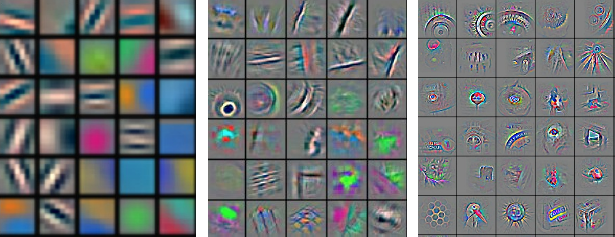

In [12]:
from IPython.display import Image
Image(filename='conv.png', width=400, height=200) 

In [13]:
# Above, we discussed the motivation behind a locally connected network with parameter sharing.
# In most machine learning context, you can think of your Machine Learning design based on what you want to solve.
# In image processing, this is called a "Convolutional Layer", formed into a "Convolutional Neural Network"
# If we have a lot of them.

# If we want to use this specific layer, it already exists in tensorflow and other neural network libraries.
# However, there are many times when no specific layer exists for our purposes, and we can just comfortably design our own
# Representation that applies the correct connection structure and parameter sharing for our problem.
# For instance, for work I right now do marketing. For marketing, I have concepts of local connections between similar 
# Products, where products can steal sales from each other, and I also have ta concept of parameter sharing,
# Where if one product is highly effective for fb marketing, then other similar products are also probably effective as well.

In [14]:
# Starting now, we will have a lot more flexibility on solving problems. In common academic problems, 
# These questions are already answered for us without us noticing. But for any new custom problem we want to solve,
# We need to answer all of the following questions.

# How do we represent our data? (we haven't covered much of this yet)
# What should be the structure of our model? Does local connections or parameter sharing apply?
# What should be our loss function? For instance, what properties do we want? When should we get the highest gradient,
#     when should we get the lowest gradient? Loss functions are just for getting gradients to improve our model
# What should be our evaluation function? What is the metric that tells us if this model is useful for business?
#     Evaluation functions provide no gradient, but are the ones used for checking if we solve the problem.
#     For our evaluation, do we need to be worried about how well the model will predict on future data? If so we may need
#     to include Walk Forward Optimization (we will cover later)
# Custom Interpretability. Sometimes our model needs to be linearly interpretable, or interpretable in some other way.
#     If this is the cast, we need to make sure our model provides our interpretation needs.

In [15]:
#